In [1]:
import os
os.environ["OMP_NUM_THREADS"] = "8"
os.environ["DYLD_LIBRARY_PATH"] = "/Users/felipemustafa/Documents/interplay/petit/MultiNest/lib"
os.environ["LD_LIBRARY_PATH"] = "/Users/felipemustafa/Documents/interplay/petit/MultiNest/lib"

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import petitRADTRANS as prt
from petitRADTRANS.retrieval.models import guillot_transmission
from petitRADTRANS import physical_constants as cst
from petitRADTRANS.retrieval import Retrieval,RetrievalConfig
from petitRADTRANS.retrieval.models import Planet
from petitRADTRANS.retrieval.utils import log_prior
from matplotlib.patches import Rectangle
from petitRADTRANS.plotlib import plot_radtrans_opacities

from petitRADTRANS.retrieval.models import (
    isothermal_transmission,
    guillot_transmission,
    guillot_patchy_transmission,
    madhu_seager_patchy_transmission
)
from petitRADTRANS.retrieval.parameter import Parameter
from petitRADTRANS.plotlib.style import set_petitradtrans_plot_style

set_petitradtrans_plot_style()

Using pRT Plotting style!


In [2]:
planet = Planet.get("K2-18 b")
root_path = os.path.abspath(os.path.join(os.getcwd(), "../../petit"))

retrieval_config = RetrievalConfig(retrieval_name="K2-18b_guillot_non_grey_clouds_no_NH3",
                                run_mode="retrieve",
                                amr=False,
                                scattering_in_emission=True,
                                pressures=np.logspace(-6, 2, 120),
                                  )

retrieval_config.add_data(
    "K2-18b_NIRISS",
    os.path.join(root_path, "spectra/K2-18b_NIRISS.txt"),
    data_resolution=700,
    model_resolution=1500,
    model_generating_function=guillot_transmission,
    line_opacity_mode="c-k",
    external_radtrans_reference=None
)

retrieval_config.add_data(
    "K2-18b_NIRSPEC",
    os.path.join(root_path, "spectra/K2-18b_NIRSPEC.txt"),
    data_resolution=2700,
    model_resolution=1500,
    model_generating_function=guillot_transmission,
    line_opacity_mode="c-k",
    external_radtrans_reference=None
)

retrieval_config.add_parameter('D_pl', False, value=124.265*cst.light_year)
retrieval_config.add_parameter('stellar_radius', False, value=planet.star_radius)
retrieval_config.add_parameter('planet_radius', False, value = 0.211*cst.r_jup)
retrieval_config.add_parameter('mass', False, value = 0.02807*cst.m_jup)

retrieval_config.add_parameter('T_int', True, transform_prior_cube_coordinate = lambda x : 600*x)
retrieval_config.add_parameter('T_equ', True, transform_prior_cube_coordinate = lambda x : 600*x)
retrieval_config.add_parameter('gamma', True, transform_prior_cube_coordinate = lambda x : log_prior(x, -2, 1))
retrieval_config.add_parameter('log_kappa_IR', True, transform_prior_cube_coordinate = lambda x : -3+4*x)
retrieval_config.add_parameter('fsed_H2O(l)', True, transform_prior_cube_coordinate = lambda x: log_prior(x, -3, 0))
retrieval_config.add_parameter('log_kzz', True, transform_prior_cube_coordinate = lambda x: 4+8*x)
retrieval_config.add_parameter('log_X_cb_H2O(l)', True, transform_prior_cube_coordinate = lambda x: -6+6*x)
retrieval_config.add_parameter('sigma_lnorm', True, transform_prior_cube_coordinate = lambda x: 1.05+1.95*x)
retrieval_config.add_parameter('log_Pbase_H2O(l)',  True, transform_prior_cube_coordinate = lambda x: -5+5*x)
retrieval_config.add_parameter('patchiness', True, transform_prior_cube_coordinate = lambda x: 1*x)

retrieval_config.set_rayleigh_species(['H2', 'He'])
retrieval_config.set_continuum_opacities(["H2-H2","H2-He"])
retrieval_config.set_line_species(['CH4', 'CO2', 'H2O'], eq=False, abund_lim = (-8.0,-0.1))
retrieval_config.add_cloud_species('H2O(l)', eq=True)

retrieval_config.parameters['T_int'].plot_in_corner = True
retrieval_config.parameters['T_int'].corner_ranges = (0,600)
retrieval_config.parameters['T_equ'].plot_in_corner = True
retrieval_config.parameters['T_equ'].corner_ranges = (0,600)
retrieval_config.parameters['gamma'].plot_in_corner = True
retrieval_config.parameters['gamma'].corner_ranges = (-2,6)
retrieval_config.parameters['log_kappa_IR'].plot_in_corner = True
retrieval_config.parameters['log_kappa_IR'].corner_ranges = (-3,1)
retrieval_config.parameters['log_X_cb_H2O(l)'].plot_in_corner = True
retrieval_config.parameters['log_X_cb_H2O(l)'].corner_ranges = (-6,0)
retrieval_config.parameters['fsed_H2O(l)'].plot_in_corner = True
retrieval_config.parameters['fsed_H2O(l)'].corner_ranges = (0,1)
retrieval_config.parameters['sigma_lnorm'].plot_in_corner = True
retrieval_config.parameters['sigma_lnorm'].corner_ranges = (1.05,3)
retrieval_config.parameters['log_Pbase_H2O(l)'].plot_in_corner = True
retrieval_config.parameters['log_Pbase_H2O(l)'].corner_ranges = (-5,2)

for spec in retrieval_config.line_species:
    retrieval_config.parameters[spec].plot_in_corner = True
    retrieval_config.parameters[spec].corner_ranges = (-8.2,0.2)

retrieval_config.plot_kwargs["spec_xlabel"] = 'Wavelength [micron]'
retrieval_config.plot_kwargs["spec_ylabel"] = r'$(R_{\rm P}/R_*)^2$ [ppm]'
retrieval_config.plot_kwargs["y_axis_scaling"] = 1e6 # so we have units of ppm
retrieval_config.plot_kwargs["xscale"] = 'linear'
retrieval_config.plot_kwargs["yscale"] = 'linear'

# Use at least ~100 samples to plot 3 sigma curves
retrieval_config.plot_kwargs["nsample"] = 100

retrieval_config.plot_kwargs["take_PTs_from"] = "K2-18b_NIRISS"
retrieval_config.plot_kwargs["temp_limits"] = [100, 800]
retrieval_config.plot_kwargs["press_limits"] = [1e-6, 1e2]

output_directory = os.path.join(root_path, "outputs")
retrieval = Retrieval(retrieval_config,
                      output_directory=output_directory,
                      use_mpi = False,        # Run locally, don't need to use MPI for massive parallelisation
                      evaluate_sample_spectra=False,      # Output the spectrum from nsample random samples.
                      use_prt_plot_style=True,
                      ultranest=False)        # Let's use pyMultiNestopacities = plot_radtrans_opacities(

retrieval.run(n_live_points=100,         # PMN number of live points. 400 is good for small retrievals, 4000 for large
              const_efficiency_mode=False, # Turn PMN const efficiency mode on or off (recommend on for large retrievals)
              resume=True,
              error_checking=False) 

Setting up Radtrans object for data 'K2-18b_NIRISS'...
Loading Radtrans opacities...
 Loading line opacities of species 'CH4.R1500' from file '/Users/felipemustafa/Documents/interplay/petit/input_data/opacities/lines/correlated_k/CH4/12C-1H4/12C-1H4__YT34to10.R1000_0.3-50mu.ktable.petitRADTRANS.h5'... Done.
 Loading line opacities of species 'CO2.R1500' from file '/Users/felipemustafa/Documents/interplay/petit/input_data/opacities/lines/correlated_k/CO2/12C-16O2/12C-16O2__UCL-4000.R1000_0.3-50mu.ktable.petitRADTRANS.h5'... Done.
 Loading line opacities of species 'H2O.R1500' from file '/Users/felipemustafa/Documents/interplay/petit/input_data/opacities/lines/correlated_k/H2O/1H2-16O/1H2-16O__POKAZATEL.R1000_0.3-50mu.ktable.petitRADTRANS.h5'... Done.
 Successfully loaded all line opacities
 Loading CIA opacities for H2-H2 from file '/Users/felipemustafa/Documents/interplay/petit/input_data/opacities/continuum/collision_induced_absorptions/H2--H2/H2--H2-NatAbund/H2--H2-NatAbund__BoRi.R83

Not in evaluate mode. Changing run mode to evaluate.

Plotting Best-fit spectrum
Best fit likelihood = 28830.77
T_int 129.09005185105215
T_equ 97.9298083599211
gamma 0.6904572892505172
log_kappa_IR -0.1942724108986038
log_X_cb_H2O(l) -3.568126460658279
fsed_H2O(l) 1.6040422118281175
log_cloud_radius_H2O(l) -5.381348073259377
log_Pbase_H2O(l) 1.6471936418044217
sigma_lnorm 2.0041019569941456
CH4 -2.1057959262686348
CO2 -1.8118687570931105
H2O -6.3174034351899175
NH3 -6.401193647329447
Loading Radtrans opacities...
 Loading line opacities of species 'CH4' from file '/home/juan/petitRADTRANS/input_data/opacities/lines/correlated_k/CH4/12C-1H4/12C-1H4__YT34to10.R1000_0.3-50mu.ktable.petitRADTRANS.h5'... Done.
 Loading line opacities of species 'CO2' from file '/home/juan/petitRADTRANS/input_data/opacities/lines/correlated_k/CO2/12C-16O2/12C-16O2__UCL-4000.R1000_0.3-50mu.ktable.petitRADTRANS.h5'... Done.
 Loading line opacities of species 'H2O' from file '/home/juan/petitRADTRANS/input_data

/home/juan/retrievals/petit/lib/python3.10/site-packages/petitRADTRANS/retrieval/retrieval.py:4413: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


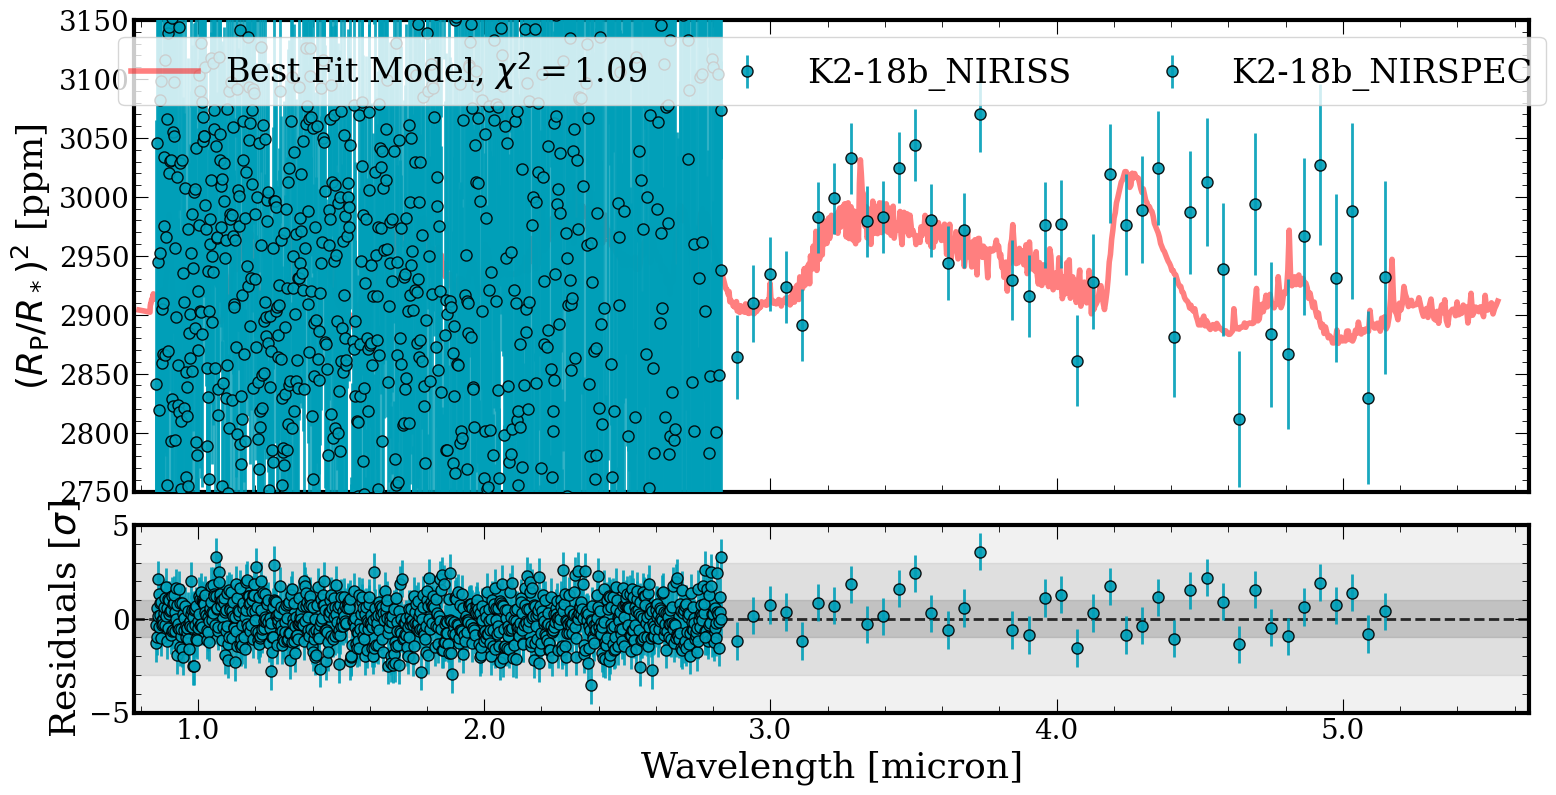

In [5]:
sample_dict, parameter_dict = retrieval.get_samples(output_directory=output_directory)
samples_use = sample_dict[retrieval.configuration.retrieval_name]
parameters_read = parameter_dict[retrieval.configuration.retrieval_name]


fig,ax,ax_r = retrieval.plot_spectra(samples_use, parameters_read, refresh = True, mode = 'bestfit')
ax.set_ylim(2750, 3150)
plt.show()


Plotting PT profiles


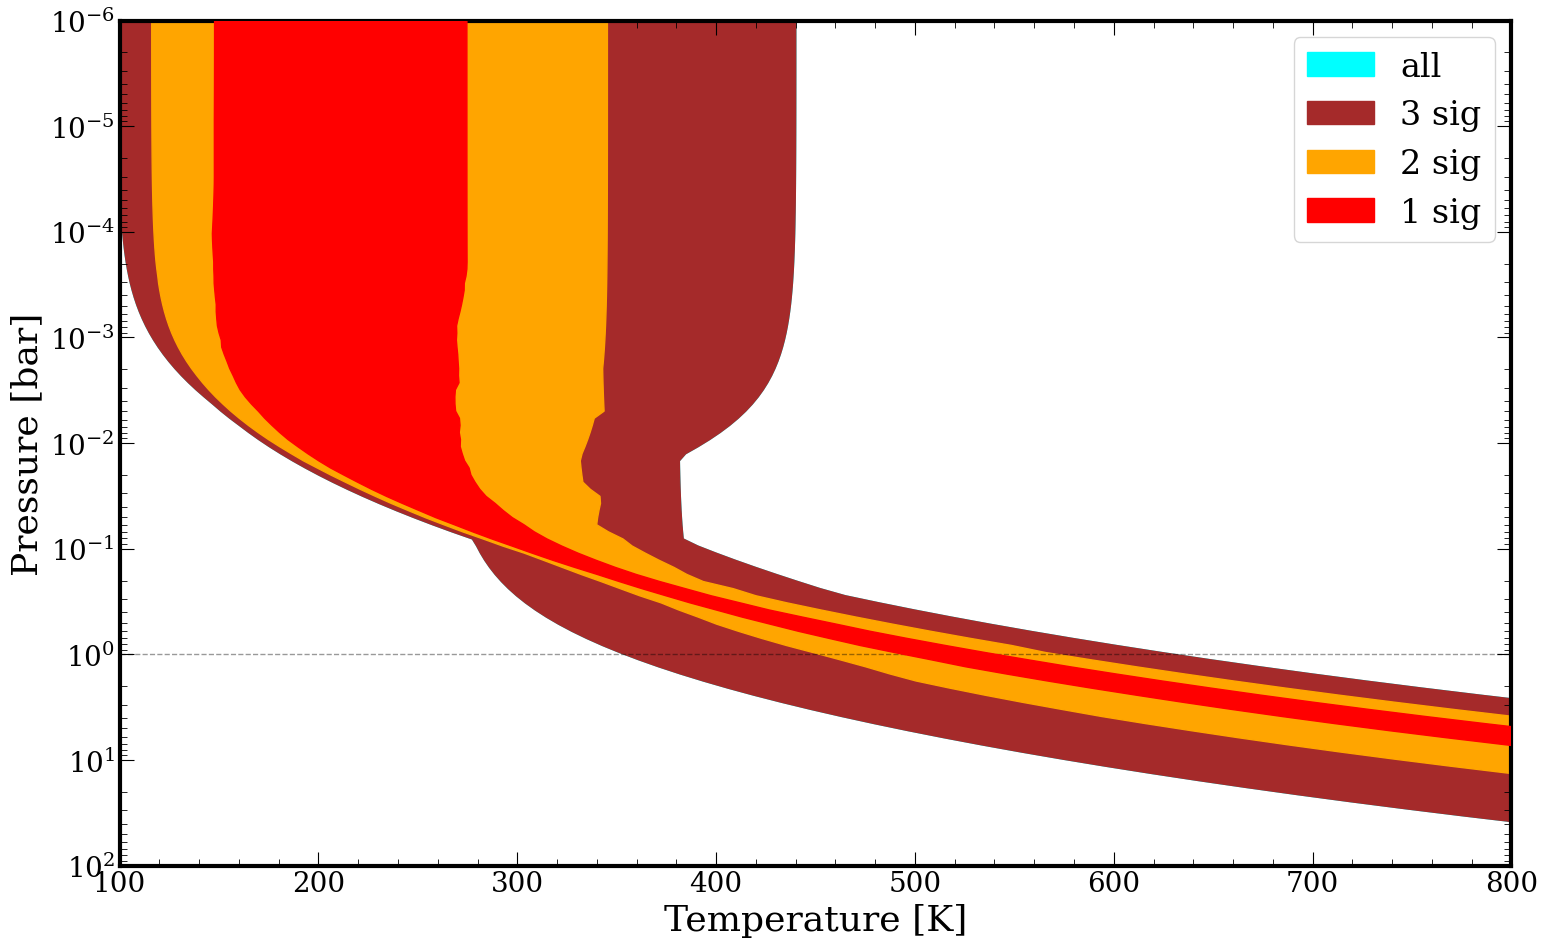

In [6]:
fig, ax = retrieval.plot_pt(sample_dict,parameters_read, contribution=False)
ax.axhline(y=0.986923, linestyle="--", color="k", linewidth=1, alpha=0.4)
ax.invert_yaxis()
plt.show()


Making corner plot


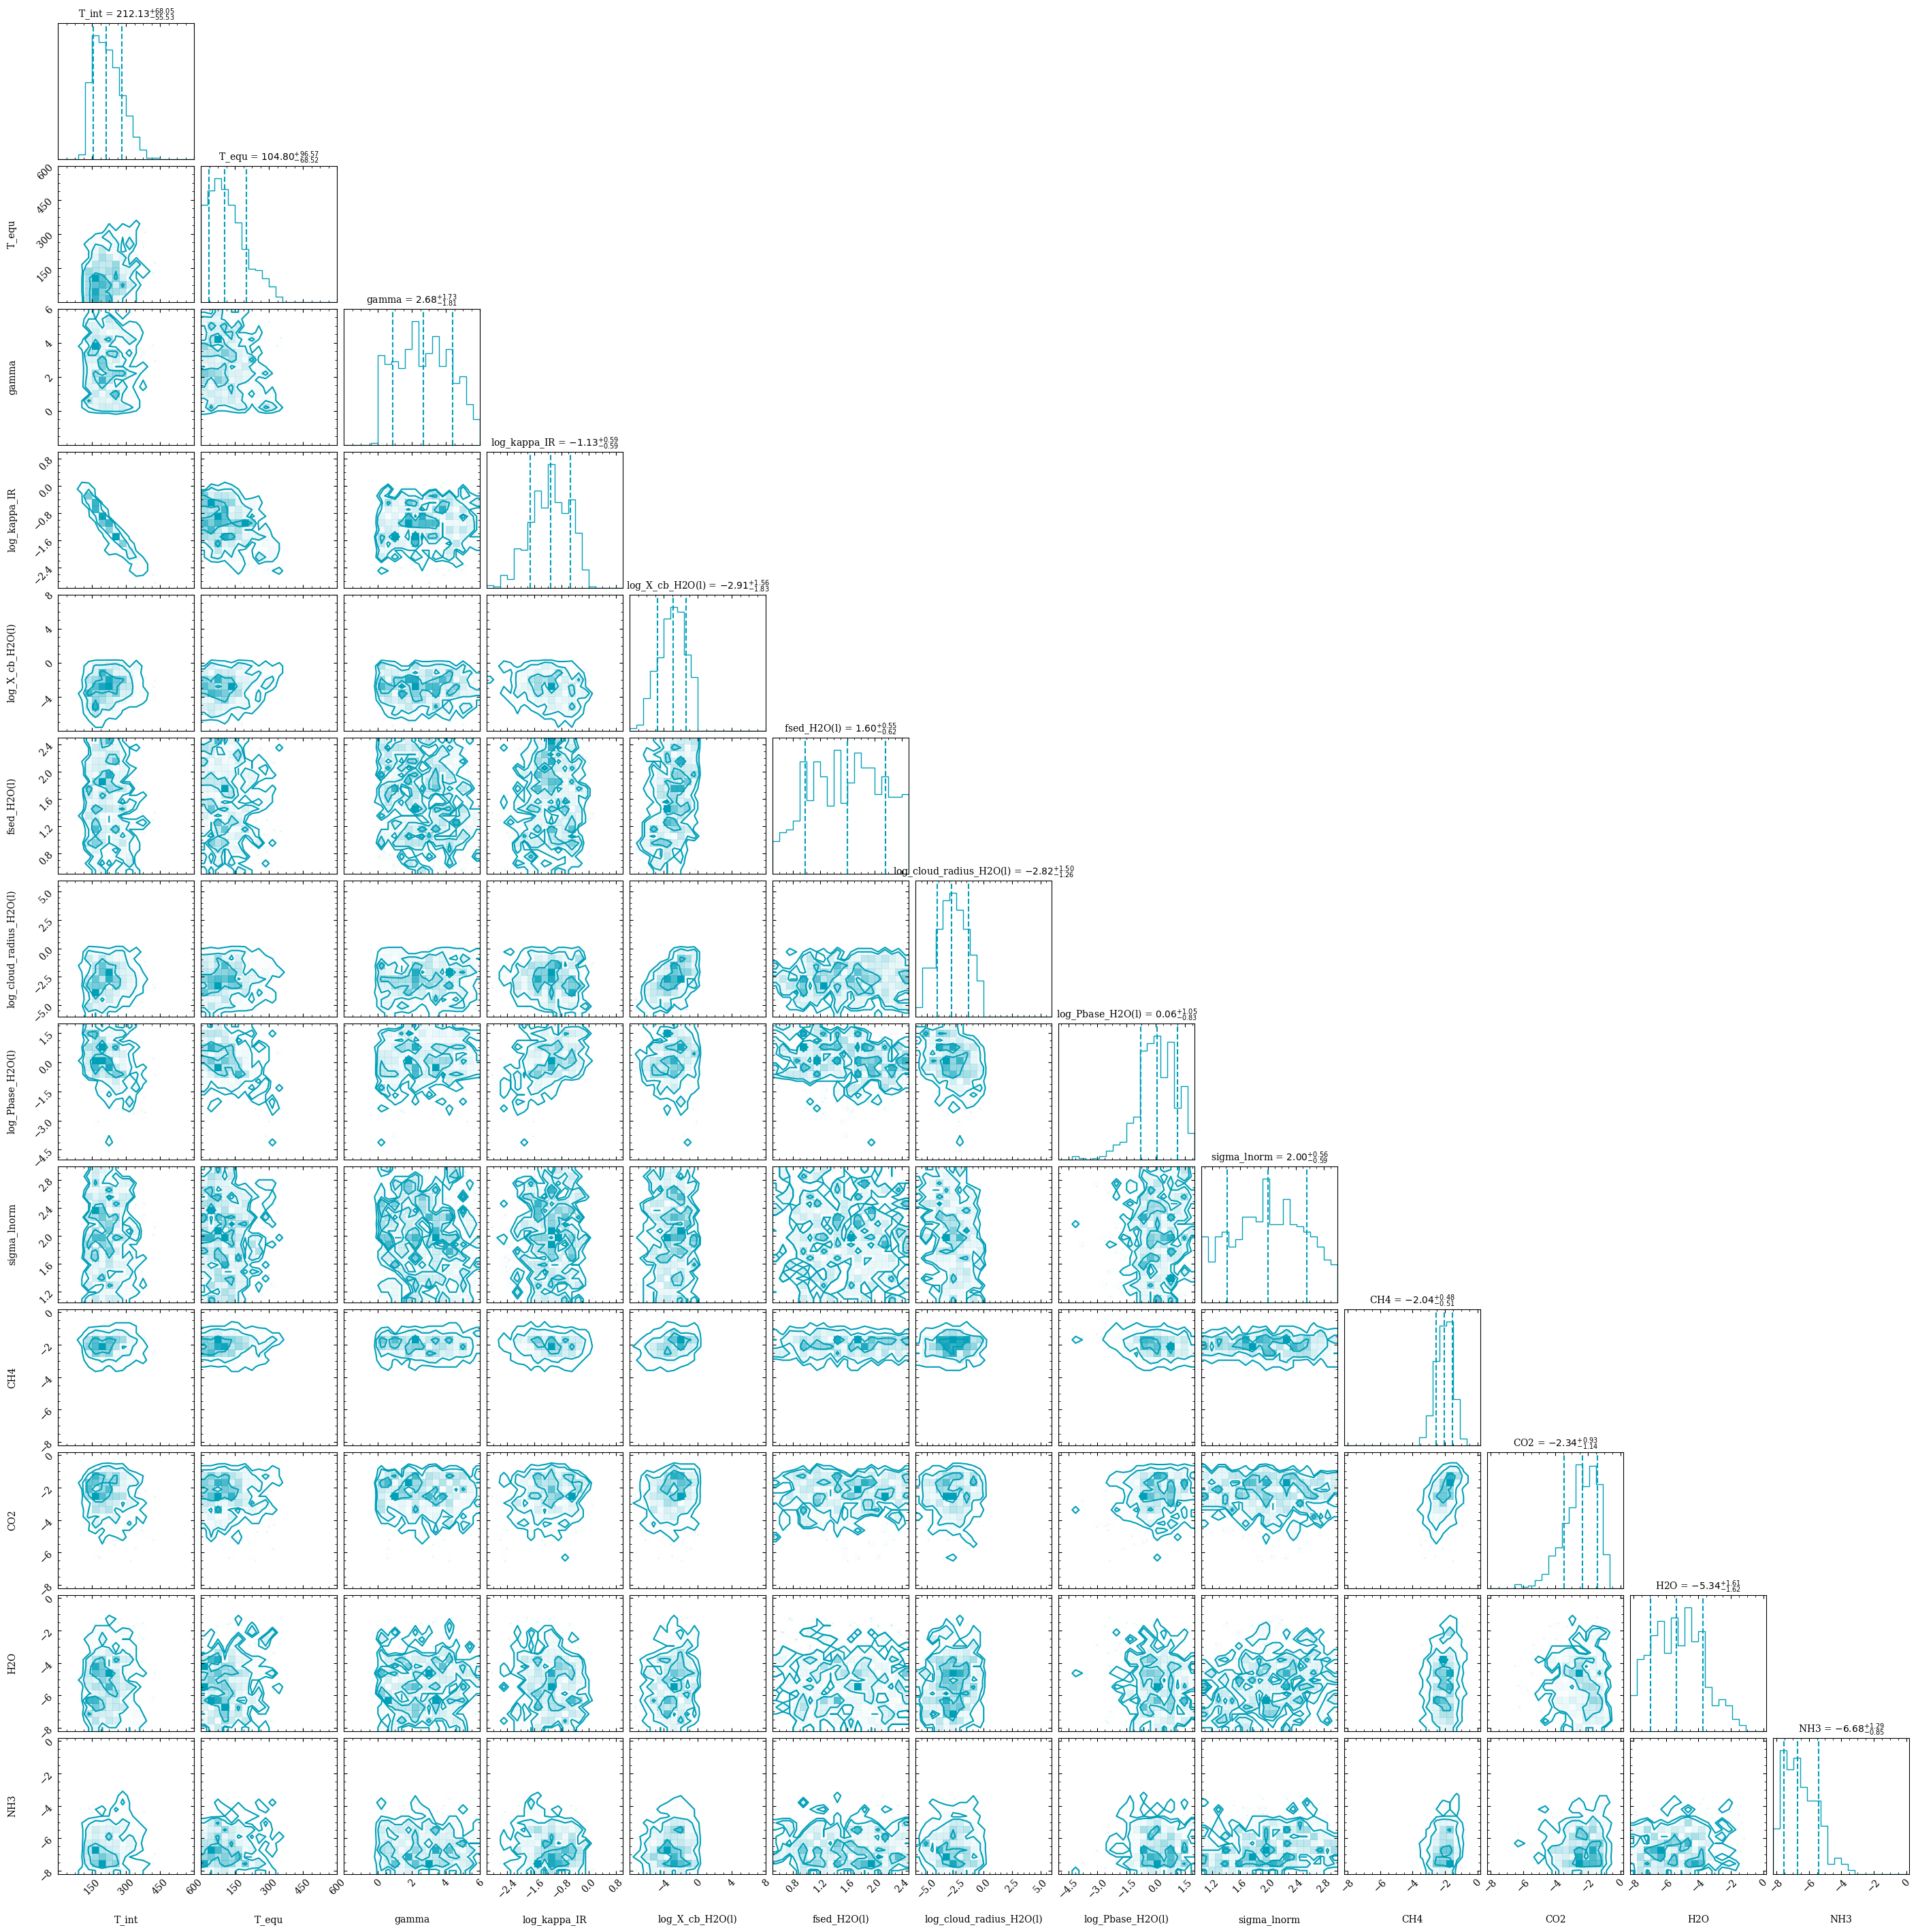

In [7]:
retrieval.plot_corner(sample_dict, parameter_dict, parameters_read, title_kwargs= {"fontsize" : 10})
plt.show()

In [8]:
parameters = {
    'stellar_radius': Parameter('stellar_radius', False, value= planet.star_radius),
    'planet_radius': Parameter('planet_radius', False, value= 0.211*cst.r_jup),
    'mass': Parameter('mass', False, value= 0.02807*cst.m_jup),
    'T_int': Parameter('T_int', False, value= retrieval.best_fit_parameters['T_int'].value),
    'T_equ': Parameter('T_equ', False, value= retrieval.best_fit_parameters['T_equ'].value),
    'gamma': Parameter('gamma', False, value= retrieval.best_fit_parameters['gamma'].value),
    'log_kappa_IR': Parameter('log_kappa_IR', False, value= retrieval.best_fit_parameters['log_kappa_IR'].value),
    'log_Pcloud': Parameter('log_Pcloud', False, value= retrieval.best_fit_parameters['log_Pcloud'].value),
    'patchiness': Parameter('patchiness', False, value= retrieval.best_fit_parameters['patchiness'].value),
    'CH4': Parameter('CH4', False, value= retrieval.best_fit_parameters['CH4'].value),
    'CO2': Parameter('CO2', False, value= retrieval.best_fit_parameters['CO2'].value),
    'H2O': Parameter('H2O', False, value= retrieval.best_fit_parameters['H2O'].value),
    'NH3': Parameter('NH3', False, value= retrieval.best_fit_parameters['NH3'].value),
}

line_species = [
    'CH4',
    'CO2',
    'H2O',
    'NH3'
]

rayleigh_species = ['H2', 'He']
continuum_opacities = ['H2-H2', 'H2-He']
cloud_species = []
pressures = np.logspace(-6,2,100)
wls = np.concatenate([retrieval_config.data['K2-18b_NIRISS'].wavelengths, retrieval_config.data['K2-18b_NIRSPEC'].wavelengths])

atmosphere = prt.radtrans.Radtrans(
    pressures=pressures,
    line_species=line_species,
    rayleigh_species=rayleigh_species,
    gas_continuum_contributors=continuum_opacities,
    cloud_species=cloud_species,
    wavelength_boundaries=[wls[0], wls[-1]]
)

wavelength, model = guillot_transmission(atmosphere, parameters, amr = False, pt_plot_mode = False)
pressure,temperature = guillot_transmission(atmosphere, parameters, amr = False, pt_plot_mode = True)

Loading Radtrans opacities...
 Loading line opacities of species 'CH4' from file '/home/juan/petitRADTRANS/input_data/opacities/lines/correlated_k/CH4/12C-1H4/12C-1H4__YT34to10.R1000_0.3-50mu.ktable.petitRADTRANS.h5'... Done.
 Loading line opacities of species 'CO2' from file '/home/juan/petitRADTRANS/input_data/opacities/lines/correlated_k/CO2/12C-16O2/12C-16O2__UCL-4000.R1000_0.3-50mu.ktable.petitRADTRANS.h5'... Done.
 Loading line opacities of species 'H2O' from file '/home/juan/petitRADTRANS/input_data/opacities/lines/correlated_k/H2O/1H2-16O/1H2-16O__POKAZATEL.R1000_0.3-50mu.ktable.petitRADTRANS.h5'... Done.
 Loading line opacities of species 'NH3' from file '/home/juan/petitRADTRANS/input_data/opacities/lines/correlated_k/NH3/14N-1H3/14N-1H3__CoYuTe.R1000_0.3-50mu.ktable.petitRADTRANS.h5'... Done.
 Successfully loaded all line opacities
 Loading CIA opacities for H2-H2 from file '/home/juan/petitRADTRANS/input_data/opacities/continuum/collision_induced_absorptions/H2--H2/H2--H2-N

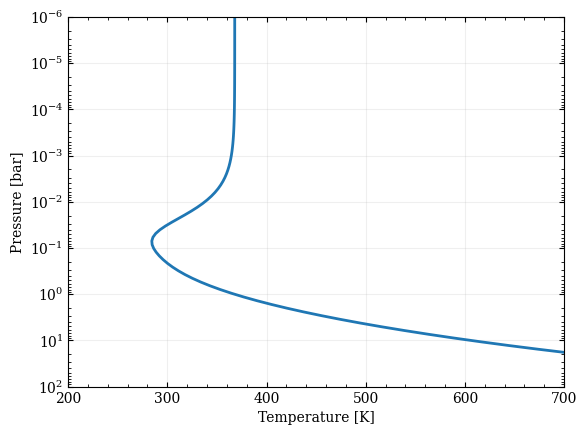

In [16]:
fig, ax = plt.subplots()
ax.plot(temperature, pressure, linewidth = 2)
ax.set_xlabel("Temperature [K]")
ax.set_ylabel(r"Pressure [bar]")
ax.set_ylim(1e2,1e-6)
ax.set_xlim(200, 700)
ax.set_yscale('log')
ax.grid(alpha=0.2)
plt.show()


Plotting Best-fit contribution function
Best fit likelihood = 28832.05
Loading Radtrans opacities...
 Loading line opacities of species 'CH4' from file '/home/juan/petitRADTRANS/input_data/opacities/lines/correlated_k/CH4/12C-1H4/12C-1H4__YT34to10.R1000_0.3-50mu.ktable.petitRADTRANS.h5'... Done.
 Loading line opacities of species 'CO2' from file '/home/juan/petitRADTRANS/input_data/opacities/lines/correlated_k/CO2/12C-16O2/12C-16O2__UCL-4000.R1000_0.3-50mu.ktable.petitRADTRANS.h5'... Done.
 Loading line opacities of species 'H2O' from file '/home/juan/petitRADTRANS/input_data/opacities/lines/correlated_k/H2O/1H2-16O/1H2-16O__POKAZATEL.R1000_0.3-50mu.ktable.petitRADTRANS.h5'... Done.
 Loading line opacities of species 'NH3' from file '/home/juan/petitRADTRANS/input_data/opacities/lines/correlated_k/NH3/14N-1H3/14N-1H3__CoYuTe.R1000_0.3-50mu.ktable.petitRADTRANS.h5'... Done.
 Successfully loaded all line opacities
 Loading CIA opacities for H2-H2 from file '/home/juan/petitRADTRANS/inpu

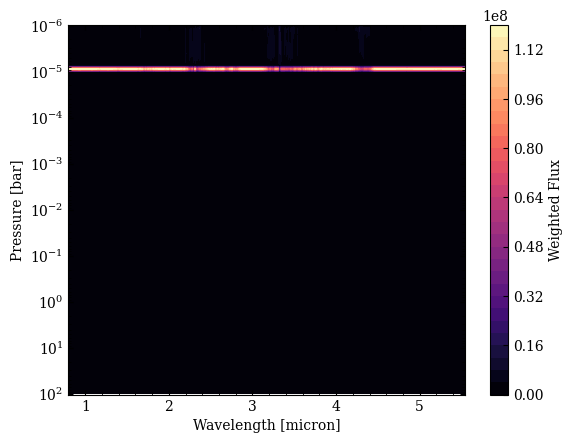

In [11]:
retrieval.plot_contribution(samples_use, parameters_read)
plt.show()

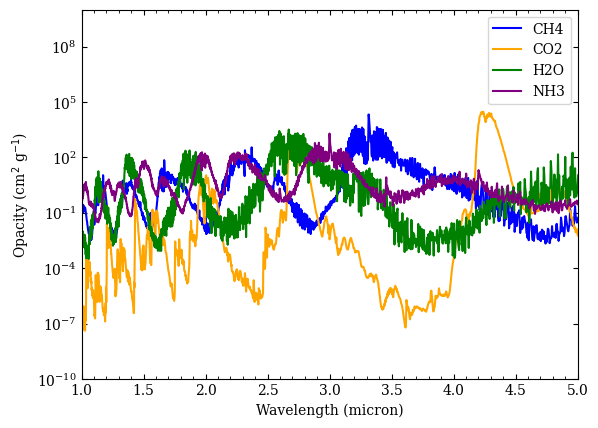

In [12]:
opacities = plot_radtrans_opacities(
    atmosphere,
    atmosphere.line_species,
    temperature=442,
    pressure_bar=1,
    return_opacities=True
)

colors = ['blue', 'orange', 'green', 'purple']
i=0
for species in opacities.keys():
    plt.plot(opacities[species][0], opacities[species][1], label=species,
             color=colors[i]
            )
    i+=1

plt.yscale('log')
plt.xlim([1,5])
plt.ylim([1e-10,1e10])
plt.ylabel('Opacity (cm$^2$ g$^{-1}$)')
plt.xlabel('Wavelength (micron)')
plt.legend()
plt.show()

Loading Radtrans opacities...
 Loading line opacities of species 'CH4' from file '/home/juan/petitRADTRANS/input_data/opacities/lines/correlated_k/CH4/12C-1H4/12C-1H4__YT34to10.R1000_0.3-50mu.ktable.petitRADTRANS.h5'... Done.
 Loading line opacities of species 'CO2' from file '/home/juan/petitRADTRANS/input_data/opacities/lines/correlated_k/CO2/12C-16O2/12C-16O2__UCL-4000.R1000_0.3-50mu.ktable.petitRADTRANS.h5'... Done.
 Loading line opacities of species 'H2O' from file '/home/juan/petitRADTRANS/input_data/opacities/lines/correlated_k/H2O/1H2-16O/1H2-16O__POKAZATEL.R1000_0.3-50mu.ktable.petitRADTRANS.h5'... Done.
 Loading line opacities of species 'NH3' from file '/home/juan/petitRADTRANS/input_data/opacities/lines/correlated_k/NH3/14N-1H3/14N-1H3__CoYuTe.R1000_0.3-50mu.ktable.petitRADTRANS.h5'... Done.
 Successfully loaded all line opacities
 Loading CIA opacities for H2-H2 from file '/home/juan/petitRADTRANS/input_data/opacities/continuum/collision_induced_absorptions/H2--H2/H2--H2-N

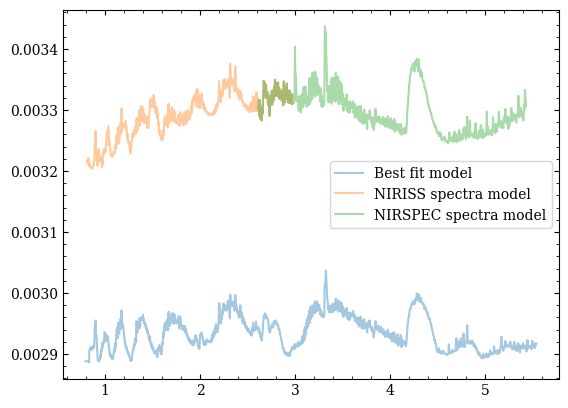

In [13]:
# retrieval.get_reduced_chi2_from_model(wavelength, model, verbose=True, show_chi2=True)

x0, y0 = retrieval.get_best_fit_model(np.array([value for item, value in retrieval.get_best_fit_parameters().items()]), parameters_read)
x1, y1 = retrieval.calculate_forward_model()["K2-18b_NIRISS"]
x2, y2 = retrieval.calculate_forward_model()["K2-18b_NIRSPEC"]
plt.plot(x0, y0, label="Best fit model", alpha=0.4)
plt.plot(x1, y1, label="NIRISS spectra model", alpha=0.4)
plt.plot(x2, y2, label="NIRSPEC spectra model", alpha=0.4)
plt.legend()
plt.show()